# Import Libraries

In [4]:
!nvidia-smi

Tue Feb 18 13:02:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
    #  transforms.Resize((28, 28)),
    #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
      transforms.Grayscale(num_output_channels=3),
      transforms.RandomRotation(10),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor(),
      #transforms.ToPILImage(),
      transforms.Normalize((0.1307,) ,(0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
      # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
    #  transforms.Resize((28, 28)),
    #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
      transforms.ToTensor(),
      #transforms.ToPILImage(),
      transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([128, 1, 28, 28])
torch.Size([128])


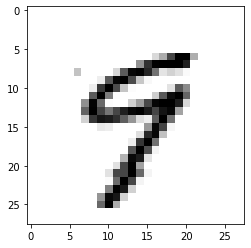

In [8]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
#train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [9]:
print(train_data.shape)
print(train_data[0].dtype)

torch.Size([60000, 28, 28])
torch.uint8


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

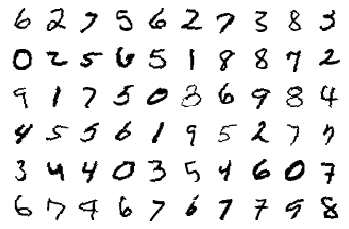

In [10]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            nn.ReLU(),
            #nn.Dropout(0.1)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(64),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [21]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
           Dropout-3           [-1, 16, 26, 26]               0
              ReLU-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
              ReLU-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
      BatchNorm2d-10           [-1, 16, 22, 22]              32
          Dropout-11           [-1, 16, 22, 22]               0
             ReLU-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [23]:
device

device(type='cuda')

In [24]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.12965011596679688 Batch_id=468 Accuracy=90.09: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0704, Accuracy: 9768/10000 (97.68%)

EPOCH: 1


Loss=0.11534828692674637 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:17<00:00, 26.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9831/10000 (98.31%)

EPOCH: 2


Loss=0.028839515522122383 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9851/10000 (98.51%)

EPOCH: 3


Loss=0.044876497238874435 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:17<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.03376587852835655 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:17<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Loss=0.05727386474609375 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.03182685747742653 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:18<00:00, 25.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.03514188900589943 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:18<00:00, 25.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.06016405299305916 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.09297788888216019 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:18<00:00, 25.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.10611063241958618 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:17<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9914/10000 (99.14%)

EPOCH: 11


Loss=0.06758814305067062 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9908/10000 (99.08%)

EPOCH: 12


Loss=0.05178700387477875 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:18<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.03374633565545082 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.016846517100930214 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:18<00:00, 32.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9907/10000 (99.07%)

EPOCH: 15


Loss=0.012606252916157246 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.02071589231491089 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9910/10000 (99.10%)

EPOCH: 17


Loss=0.10623401403427124 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 24.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9924/10000 (99.24%)

EPOCH: 18


Loss=0.006971647497266531 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:18<00:00, 25.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.015112687833607197 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:18<00:00, 32.09it/s]



Test set: Average loss: 0.0203, Accuracy: 9929/10000 (99.29%)



Text(0.5, 1.0, 'Test Accuracy')

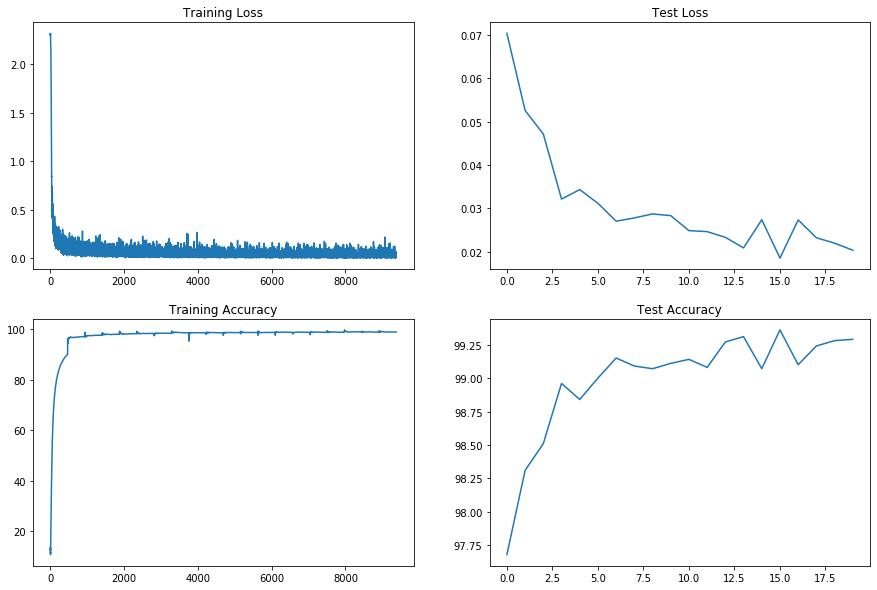

In [25]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")